# Данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (23, 9)

# Prophet



Интересные факты:
1. Можно обучаться на данных с кусочной стрктурой(например есть данные за рабочие часы с 9 до 22, а за остальное время нет => можно пихать в future только рабочие часы)
2. Регрессоры входят в линейную часть модели и регуляризуются holidays_prior_scale
3. Можно добавлять условную сезонность(разная недельная сезонность в праздники и в обычные дни)
4. После кросвалидации можно строить зависимость качества от горизонта
5. Есть распараллеливание кросвалидации на Dask
6. [Handling Shocks](https://facebook.github.io/prophet/docs/handling_shocks.html)
    - Моделирование локдауна через праздники
    - Моделирование условной сезонности до и после ковида
7. Warm-start для ускорения дообучения на новых данных(в примере ускорили в 5 раз)

# 1. Запустим дефолтную модель

### Данные

Опять видим опожую структуру данных(однако нет столбца для айдишника ряда -- можно работать только с одним)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv")
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


<Axes: xlabel='ds'>

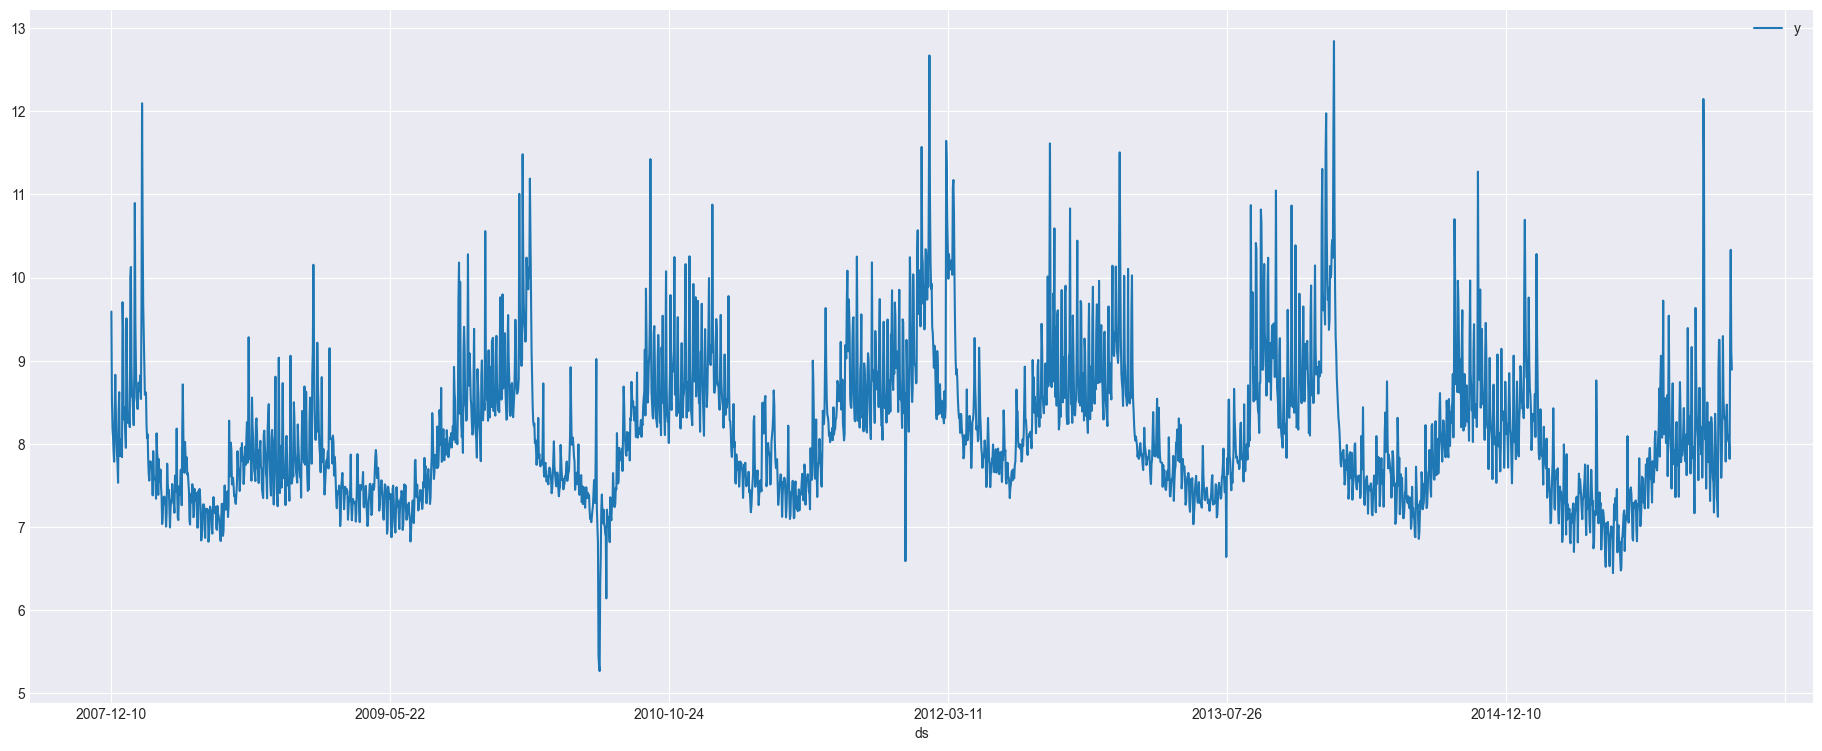

In [3]:
df.set_index("ds").plot()

### Обучение модели

In [4]:
from prophet import Prophet

In [5]:
m = Prophet()
m.fit(df)

09:25:14 - cmdstanpy - INFO - Chain [1] start processing
09:25:14 - cmdstanpy - INFO - Chain [1] done processing


### Предсказания

In [6]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

## 1. Визуализация компонент
Модель  состоит из аддитивных компонент:
$$y(t) = g(t) + s(t) + h(t) + \eta_t$$
- $g(t)$ -- тренд
- $s(t)$ -- сезонность
- $h(t)$ -- праздники + события


Все компоненты представлены в прогнозе

In [7]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,7.185960,7.437662,8.940316,6.808472,7.569160,1.018279,1.018279,1.018279,0.048295,0.048295,0.048295,0.969984,0.969984,0.969984,0.0,0.0,0.0,8.204239
3266,2017-01-16,7.184929,7.792329,9.304895,6.805369,7.569810,1.344302,1.344302,1.344302,0.352291,0.352291,0.352291,0.992010,0.992010,0.992010,0.0,0.0,0.0,8.529231
3267,2017-01-17,7.183899,7.560947,9.102422,6.802266,7.571169,1.132712,1.132712,1.132712,0.119618,0.119618,0.119618,1.013095,1.013095,1.013095,0.0,0.0,0.0,8.316611
3268,2017-01-18,7.182869,7.395760,8.847171,6.799163,7.572706,0.966375,0.966375,0.966375,-0.066658,-0.066658,-0.066658,1.033033,1.033033,1.033033,0.0,0.0,0.0,8.149244
3269,2017-01-19,7.181838,7.420908,8.905745,6.796335,7.574244,0.979304,0.979304,0.979304,-0.072277,-0.072277,-0.072277,1.051581,1.051581,1.051581,0.0,0.0,0.0,8.161142


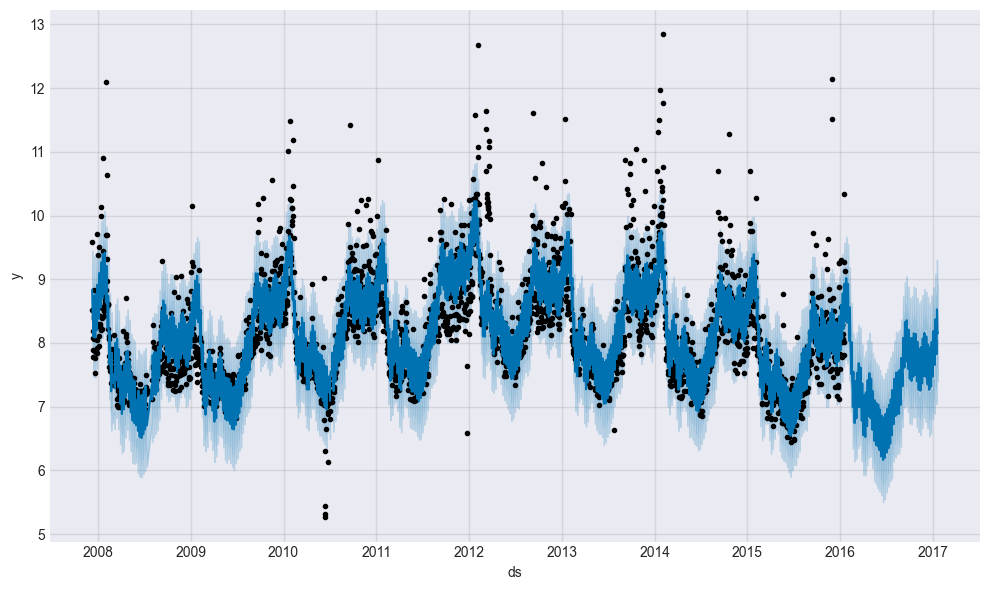

In [8]:
fig = m.plot(forecast)

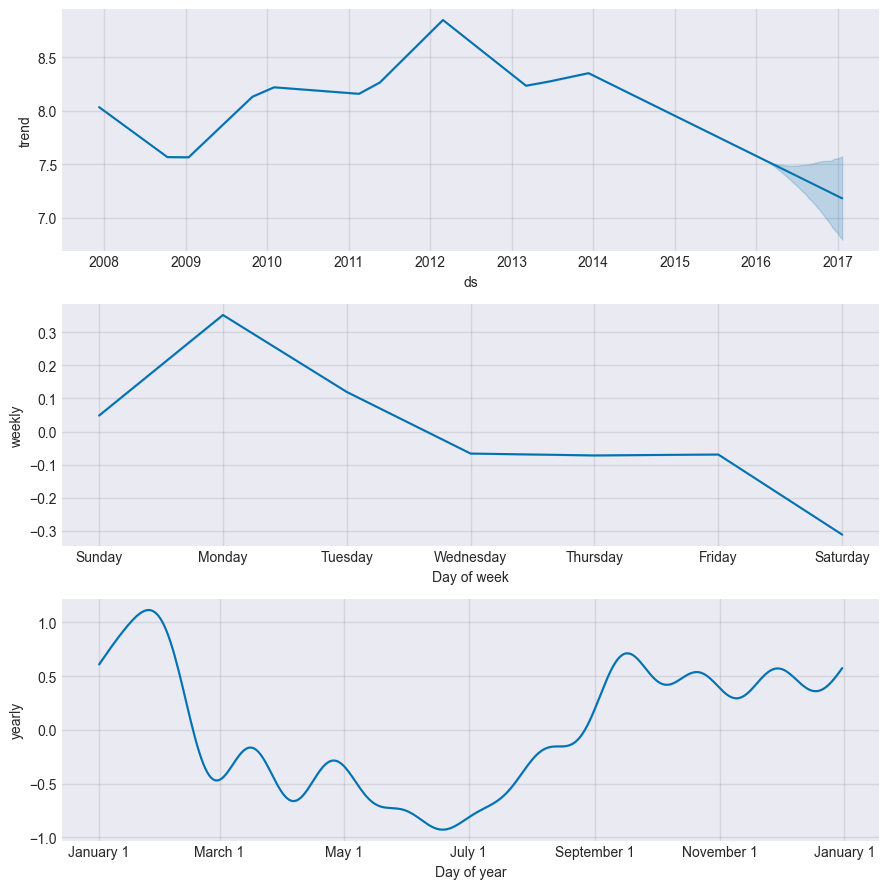

In [9]:
fig = m.plot_components(forecast)

## 2. Trend Changepoints
Можно визуализировать найденные точки смены тренда и сам тренд

In [10]:
from prophet.plot import add_changepoints_to_plot

По дефолту делается так:
- Берем 80% истории(changepoint_range)
- Равномерно раскидываем 25 точек(n_changepoints)
- Выбираем минимальный поднабор из них по некоторому критерию

Можно добавить свои точки смены тренда через `changepoints`

09:25:19 - cmdstanpy - INFO - Chain [1] start processing
09:25:19 - cmdstanpy - INFO - Chain [1] done processing


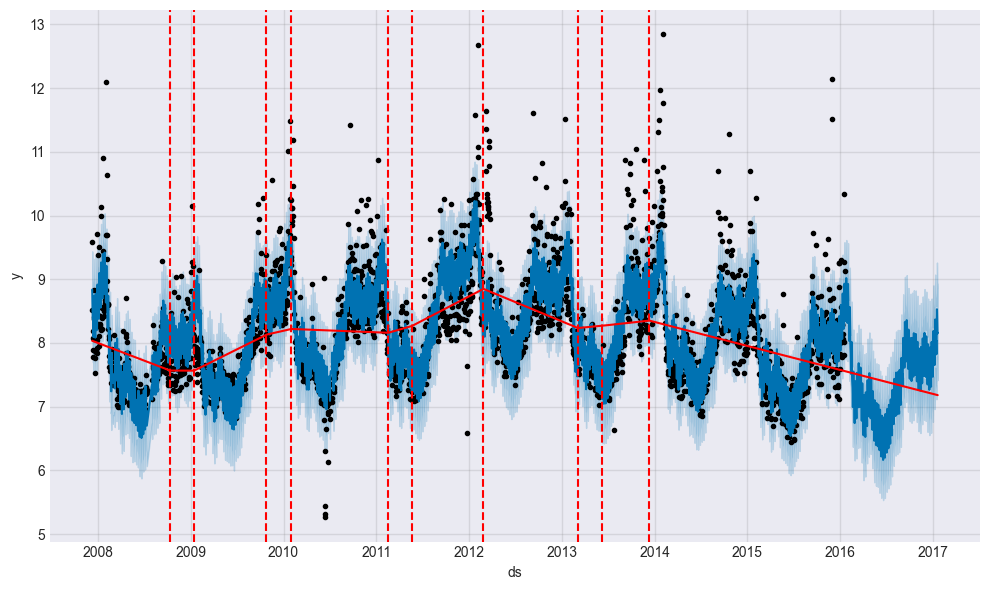

In [11]:
m = Prophet(changepoint_prior_scale=0.05)  # default

forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Можно менять консервативность тренда параметрм `changepoint_prior_scale`(чем больше тем менее консервативный)

09:25:20 - cmdstanpy - INFO - Chain [1] start processing
09:25:21 - cmdstanpy - INFO - Chain [1] done processing


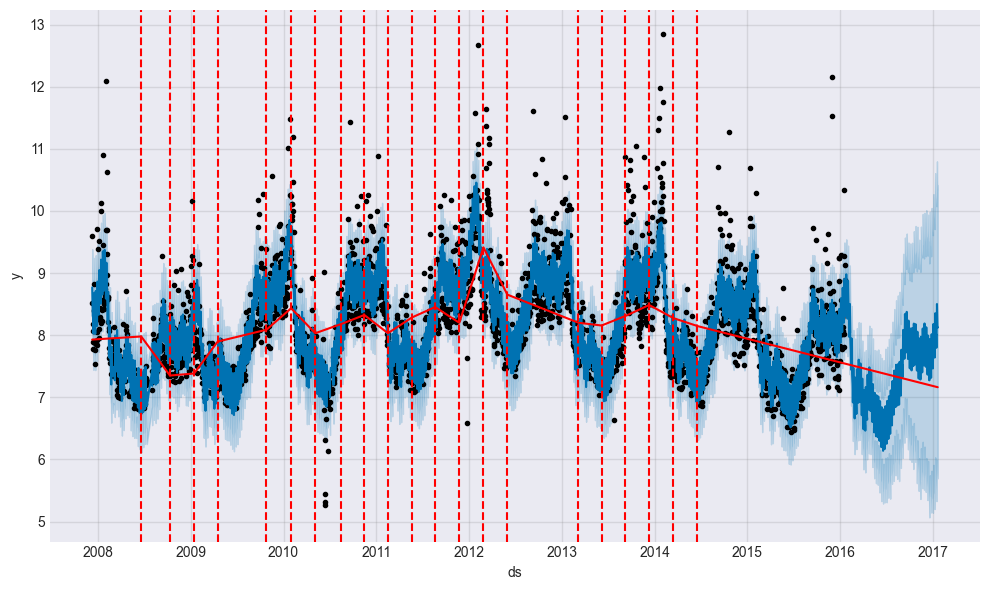

In [12]:
m = Prophet(changepoint_prior_scale=0.5)

forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## 3. Holidays

In [13]:
from prophet.plot import plot_forecast_component

Праздники задаются следующи парамтерами
- название
- список дат
- окно
- prior_scale

Можно использовать встроенные государсвенные праздники

In [14]:
playoffs = pd.DataFrame(
    {
        "holiday": "playoff",
        "ds": pd.to_datetime(
            [
                "2008-01-13",
                "2009-01-03",
                "2010-01-16",
                "2010-01-24",
                "2010-02-07",
                "2011-01-08",
                "2013-01-12",
                "2014-01-12",
                "2014-01-19",
                "2014-02-02",
                "2015-01-11",
                "2016-01-17",
                "2016-01-24",
                "2016-02-07",
            ]
        ),
        "lower_window": 0,
        "upper_window": 1,
    }
)

superbowls = pd.DataFrame(
    {
        "holiday": "superbowl",
        "ds": pd.to_datetime(["2010-02-07", "2014-02-02", "2016-02-07"]),
        "lower_window": 0,
        "upper_window": 1,
    }
)
holidays = pd.concat((playoffs, superbowls))


m = Prophet(holidays=holidays)
m.add_country_holidays("US")
forecast = m.fit(df).predict(future)

09:25:24 - cmdstanpy - INFO - Chain [1] start processing
09:25:24 - cmdstanpy - INFO - Chain [1] done processing


В прогнозе содержится влияние того или инного празника

In [15]:
forecast[forecast["holidays"].abs() > 0][["ds", "holidays"]]

,ds,holidays
15,2007-12-25,-0.427702
22,2008-01-01,-0.207652
34,2008-01-13,1.241749
35,2008-01-14,1.817391
42,2008-01-21,0.486466
...,...,...
3244,2016-12-25,-0.427702
3245,2016-12-26,-1.089188
3251,2017-01-01,-0.207652
3252,2017-01-02,0.243754


Можно визуализировать как влияние праздников в целом, так и влияние конкретного в частности

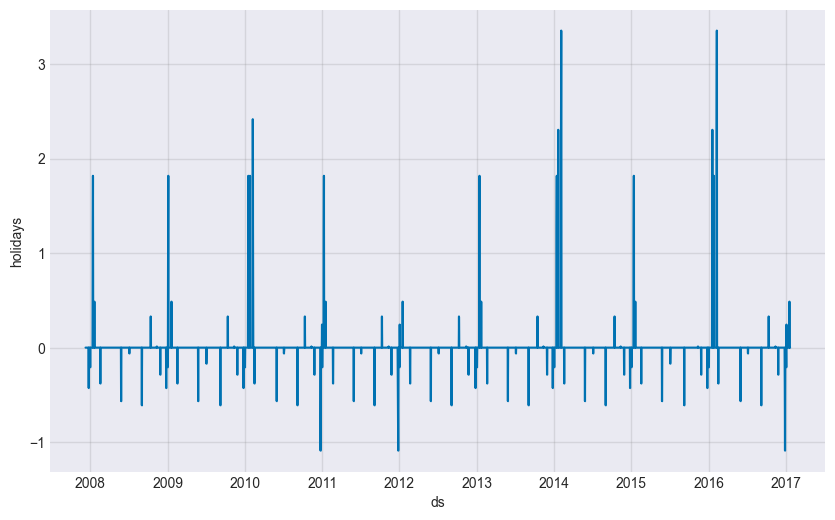

In [16]:
plot_forecast_component(m, forecast, name="holidays")

## 4. Компоненты Фурье

Можно визуализировать сезонные компоненты и подобрать по ним количество членов ряда фурье

Можно добавлять любые виды сезонности, в том числе делать разные сезонности для разных периодов времени(летом одна/зимой другая)
```
add_seasonality(name, period, fourier_order, condition_name, prior_scale)
```
- fourier_order -- количесвто членов ряда
- condition_name -- имя колонки с бинарным флагов(начало/конец года)
- prior_scale -- регуляризация(чем меньше, тем консервативнее)

09:25:27 - cmdstanpy - INFO - Chain [1] start processing
09:25:28 - cmdstanpy - INFO - Chain [1] done processing


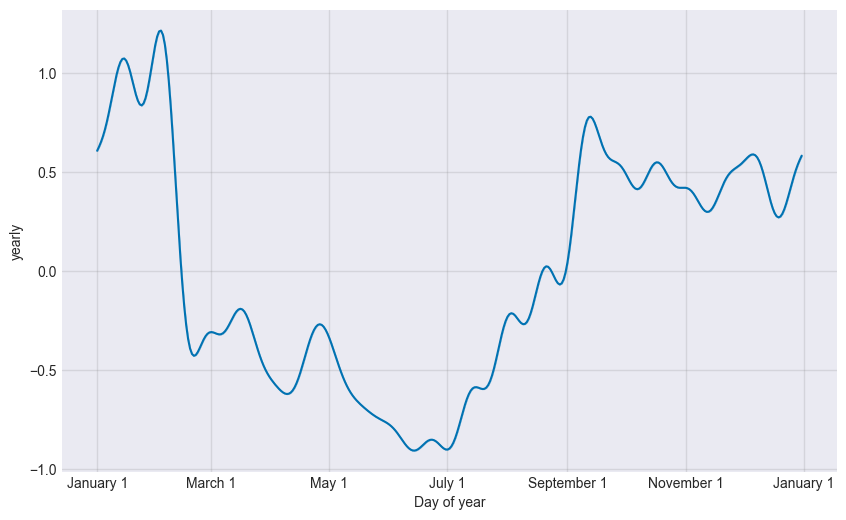

In [17]:
from prophet.plot import plot_yearly

m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

09:25:28 - cmdstanpy - INFO - Chain [1] start processing
09:25:29 - cmdstanpy - INFO - Chain [1] done processing


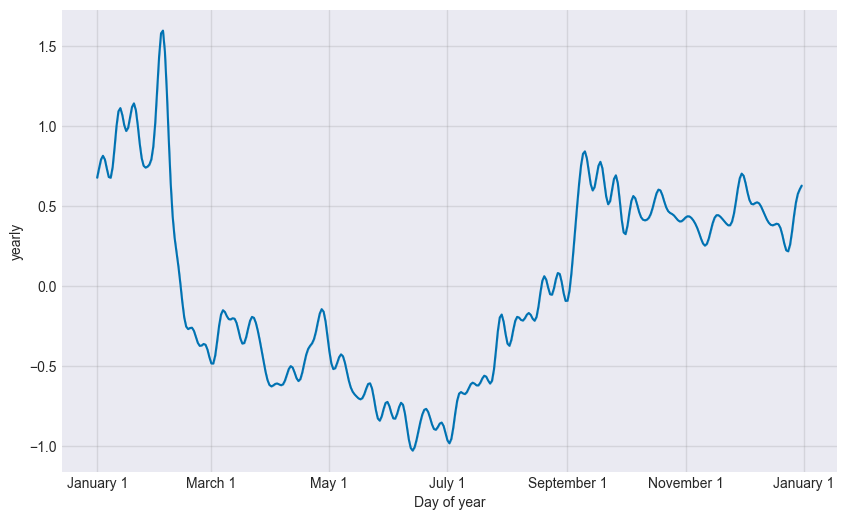

In [18]:
m = Prophet(yearly_seasonality=50).fit(df)
a = plot_yearly(m)

## 4* Кастомные сезонности

В модель встроены дневаня, недельная и годовая сезонности, посмотрим как добавить что-то поверх

In [19]:
from etna.datasets.internal_datasets import load_dataset
from pathlib import Path

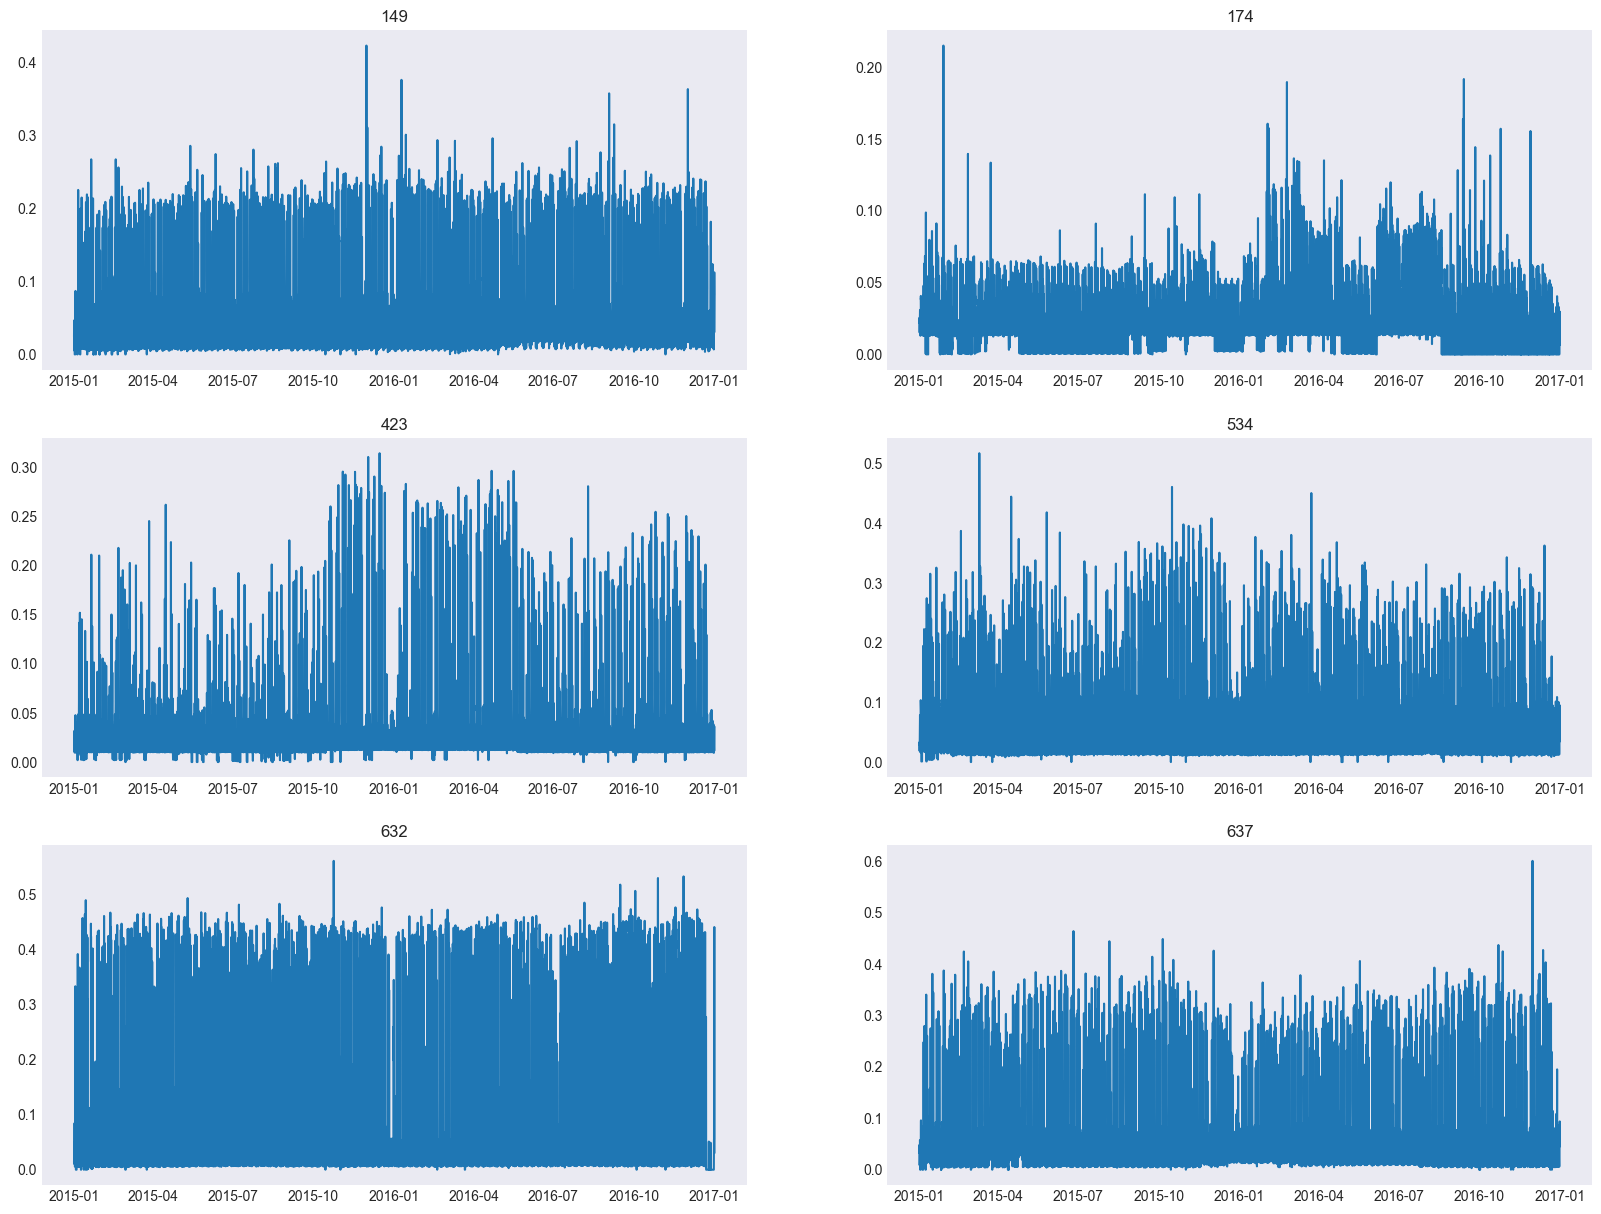

In [20]:
ts = load_dataset(name="traffic_2015_hourly", download_path=Path("data/"))
ts.plot(n_segments=6)

In [21]:
df = (
    ts.to_pandas(flatten=True)
    .query("segment=='149'")
    .rename(columns={"timestamp": "ds", "target": "y"})
    .drop(columns=["segment"])
)
df.head()

,ds,y
982464,2015-01-01 00:00:00,0.0244
982465,2015-01-01 01:00:00,0.0298
982466,2015-01-01 02:00:00,0.0186
982467,2015-01-01 03:00:00,0.0094
982468,2015-01-01 04:00:00,0.0059


Просто по картинке и по ACF видно, что в ряду 2 сезонности -- дневная и недельная. В предыдущих моделях(HOLT/SARIMAX) мы могли учитывать только 1

<Axes: xlabel='ds'>

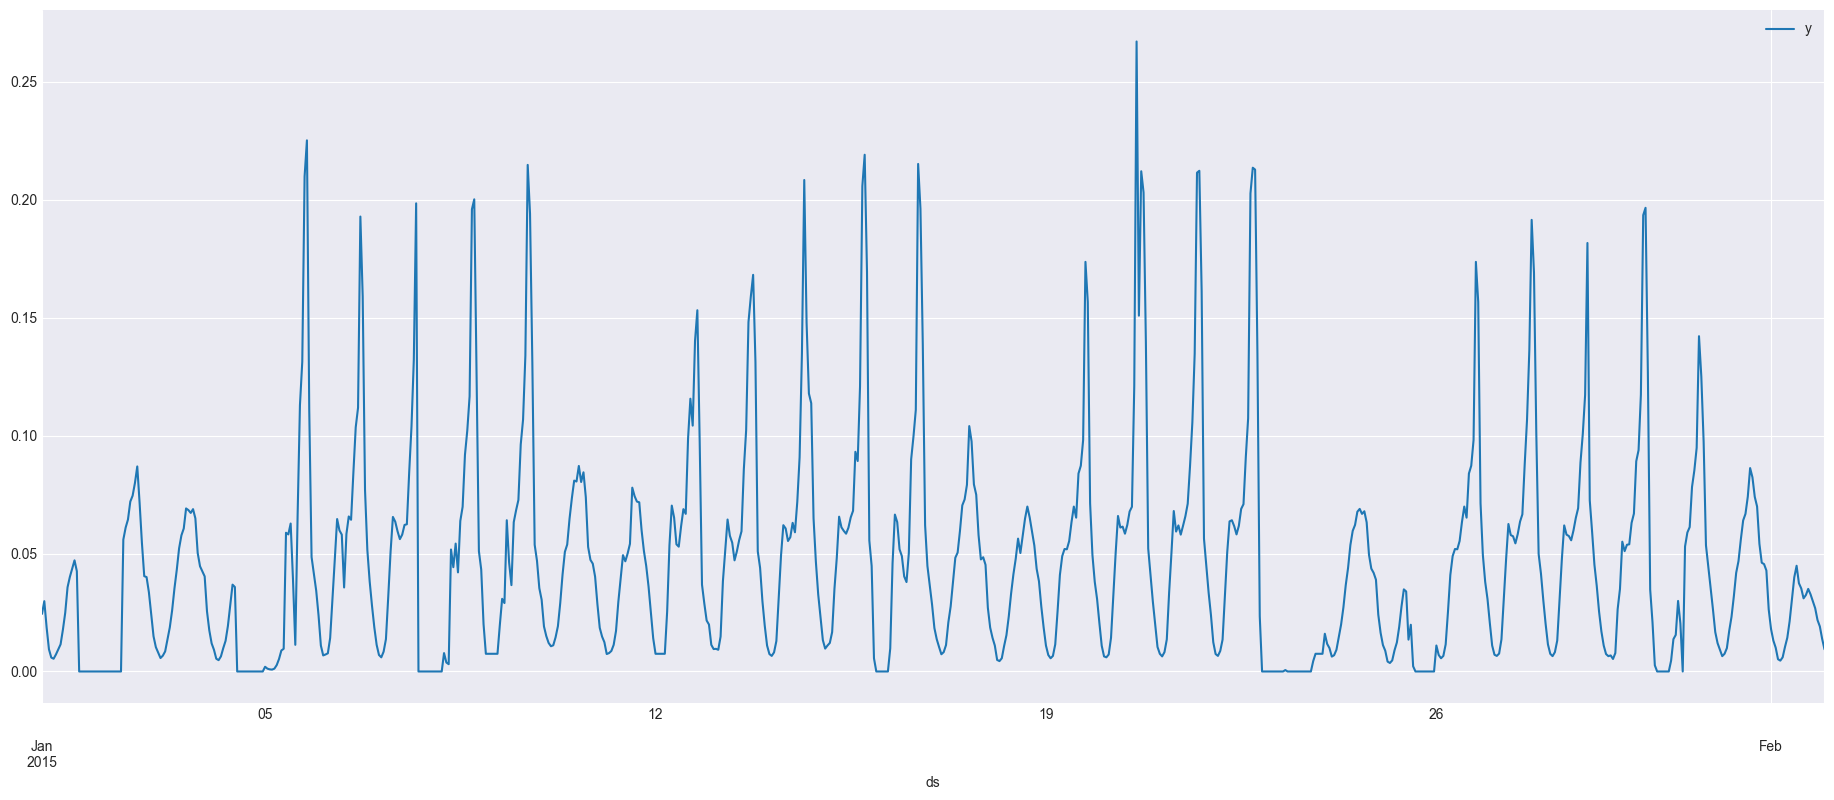

In [22]:
df.set_index("ds")["2015-01-01":"2015-02-01"].plot()

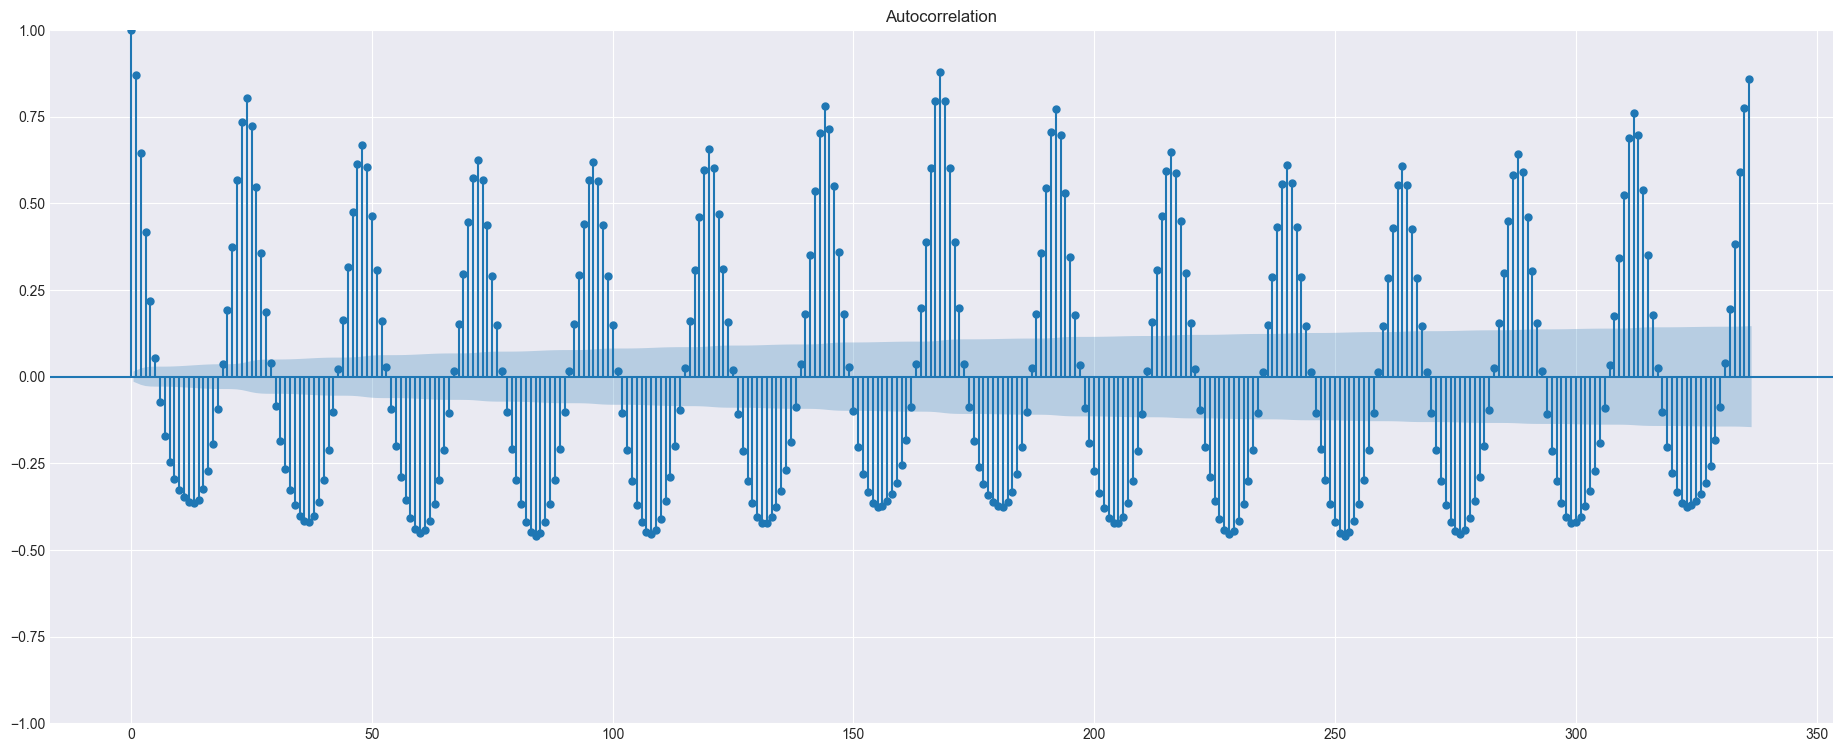

In [23]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(df["y"].values.squeeze(), lags=24 * 14);

Отключим дефолтные сезонности

09:25:36 - cmdstanpy - INFO - Chain [1] start processing
09:25:36 - cmdstanpy - INFO - Chain [1] done processing


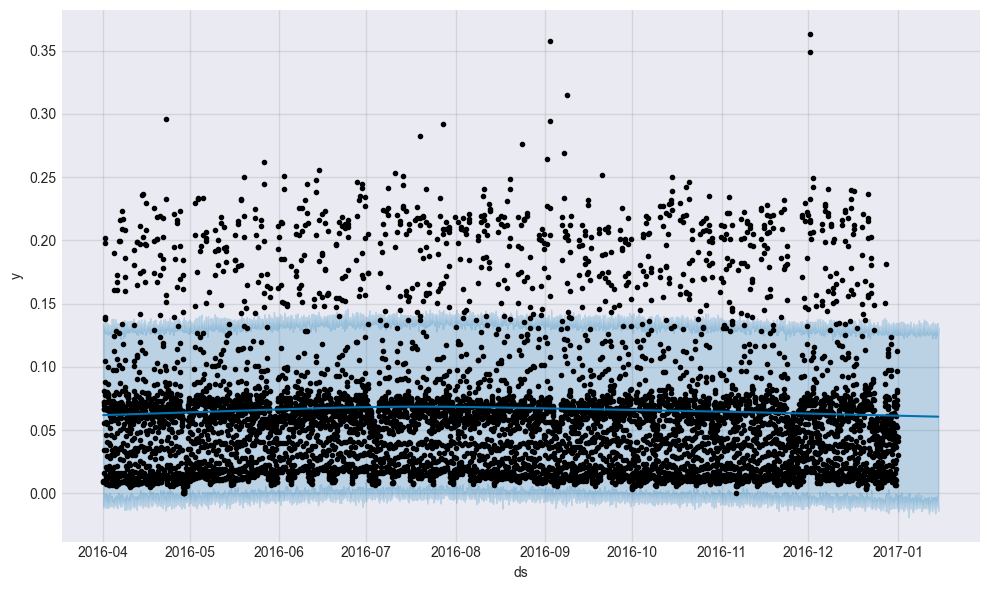

In [24]:
m = Prophet(weekly_seasonality=False, daily_seasonality=False)

m.fit(df[df["ds"] > "2016-04-01"])

future = m.make_future_dataframe(24 * 14, freq="H")
forecast = m.predict(future)
fig = m.plot(forecast)

Добавим сезонности руками

09:25:37 - cmdstanpy - INFO - Chain [1] start processing
09:25:38 - cmdstanpy - INFO - Chain [1] done processing


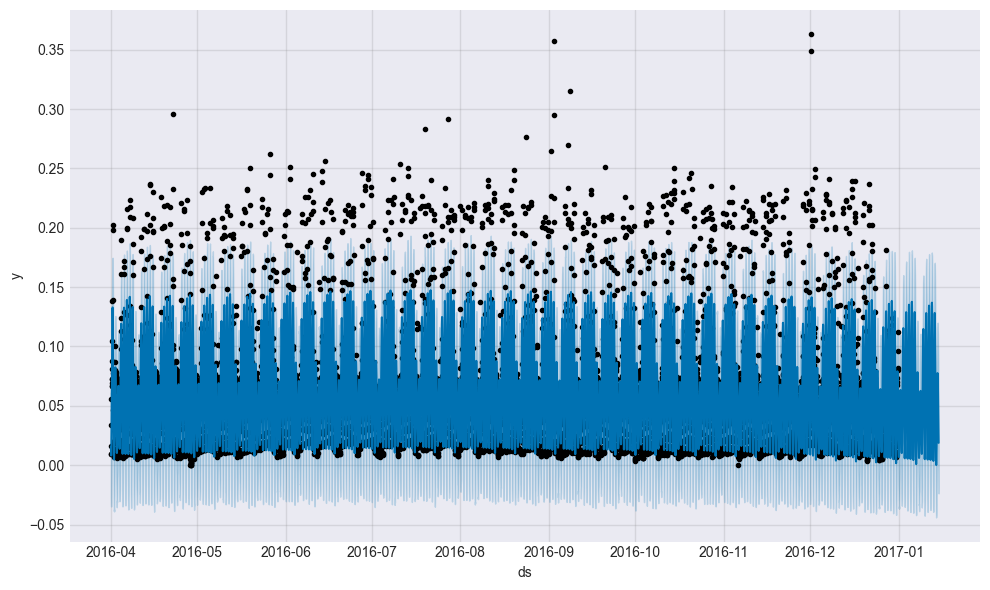

In [25]:
m = Prophet(weekly_seasonality=False, daily_seasonality=False)
m.add_seasonality(name="weekly", period=7, fourier_order=10)  # period = дни
m.add_seasonality(name="daily", period=1 / 24, fourier_order=10)

m.fit(df[df["ds"] > "2016-04-01"])

future = m.make_future_dataframe(24 * 14, freq="H")
forecast = m.predict(future)
fig = m.plot(forecast)

## 5. Регрессоры

Добавление регрессоров реализовано через интерфейс:
```
add_regressor(name, prior_scale, standardize, mode)
```
- name -- название колонки
- prior_scale -- регуляризация(по умолчанию holidays_prior_scale)
- standardize -- стандартизация(по умолчанию включена)
- mode -- 'additive'/'multiplicative'

Регрессоры добавляются в **линейную** компоненту модели

In [26]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0


df["nfl_sunday"] = df["ds"].apply(nfl_sunday)

m = Prophet()
m.add_regressor("nfl_sunday")
m.fit(df)

future["nfl_sunday"] = future["ds"].apply(nfl_sunday)

forecast = m.predict(future)

09:25:39 - cmdstanpy - INFO - Chain [1] start processing
09:25:41 - cmdstanpy - INFO - Chain [1] done processing


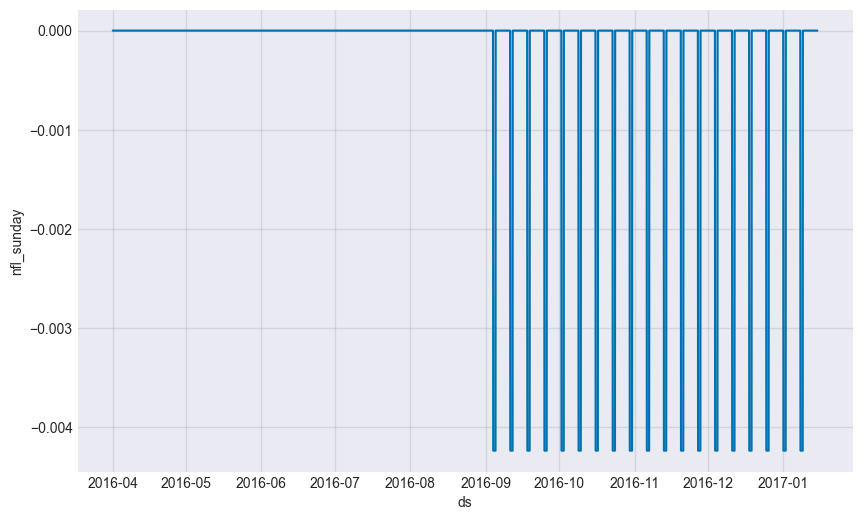

In [27]:
plot_forecast_component(m, forecast, "nfl_sunday");

- Можно достать коэффициенты регрессоров в линейной модели

In [28]:
from prophet.utilities import regressor_coefficients

In [29]:
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,nfl_sunday,additive,0.0,-0.004239,-0.004239,-0.004239


## 5* Учет внешних событий 

Рассмотрим временной ряд посещений страницы википении декоторого сериала -- пики это выходы его сезонов


<Axes: xlabel='ds'>

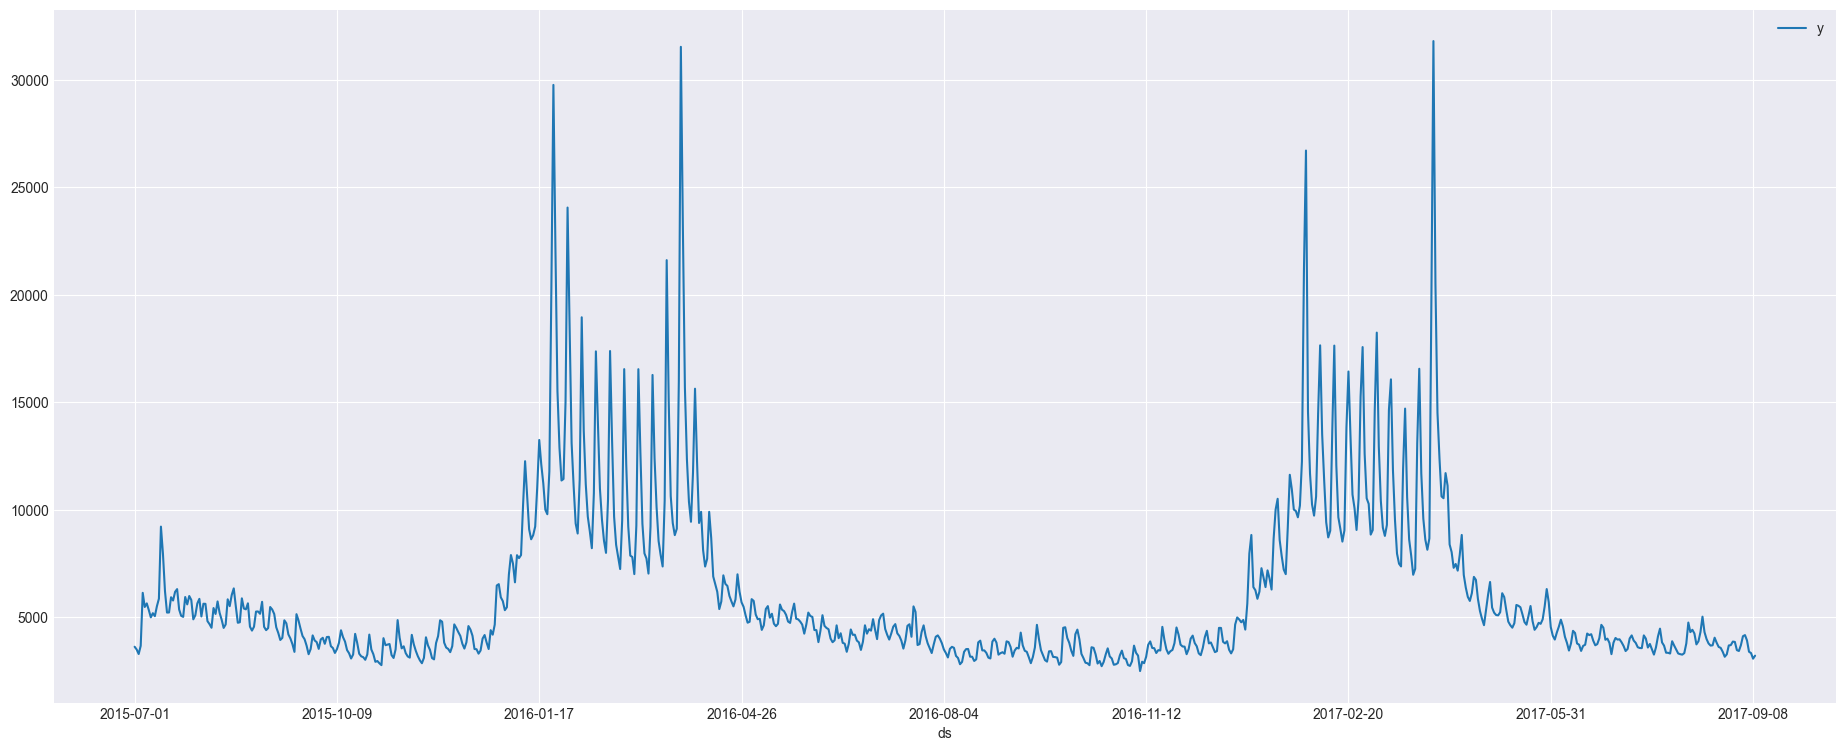

In [30]:
df = pd.read_csv("data/wikipedia/sample.csv")
df_train = df[df["ds"] < "2016-09-10"]

df.set_index("ds").plot()

Попробуем спрогнозировать трафик на страницу на следующий год

09:25:41 - cmdstanpy - INFO - Chain [1] start processing
09:25:42 - cmdstanpy - INFO - Chain [1] done processing


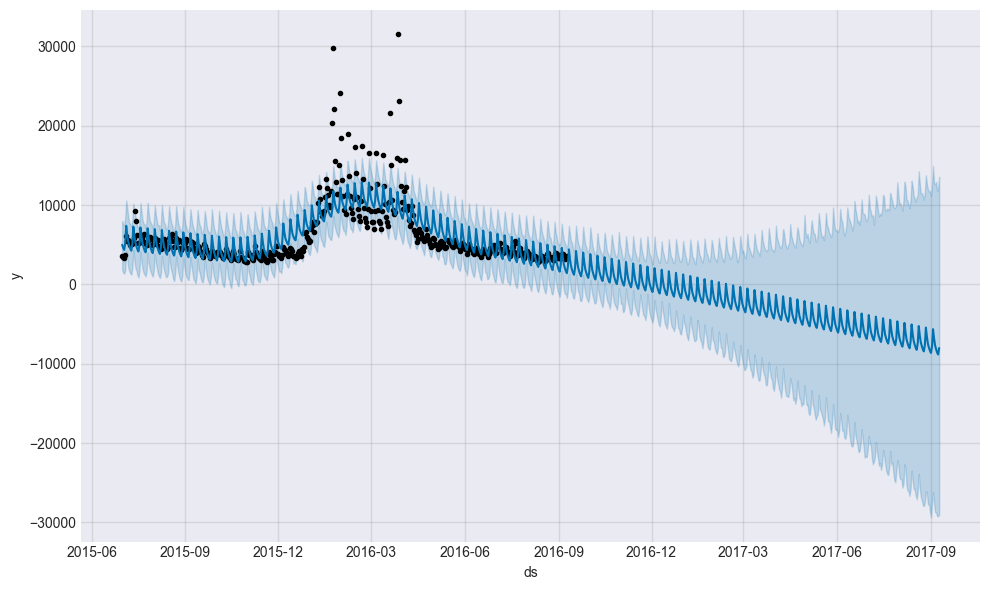

In [31]:
m = Prophet()
m.fit(df_train)

future = m.make_future_dataframe(365)
forecast = m.predict(future)
fig = m.plot(forecast)

В явном виде включим годовую сезонность

09:25:42 - cmdstanpy - INFO - Chain [1] start processing
09:25:42 - cmdstanpy - INFO - Chain [1] done processing


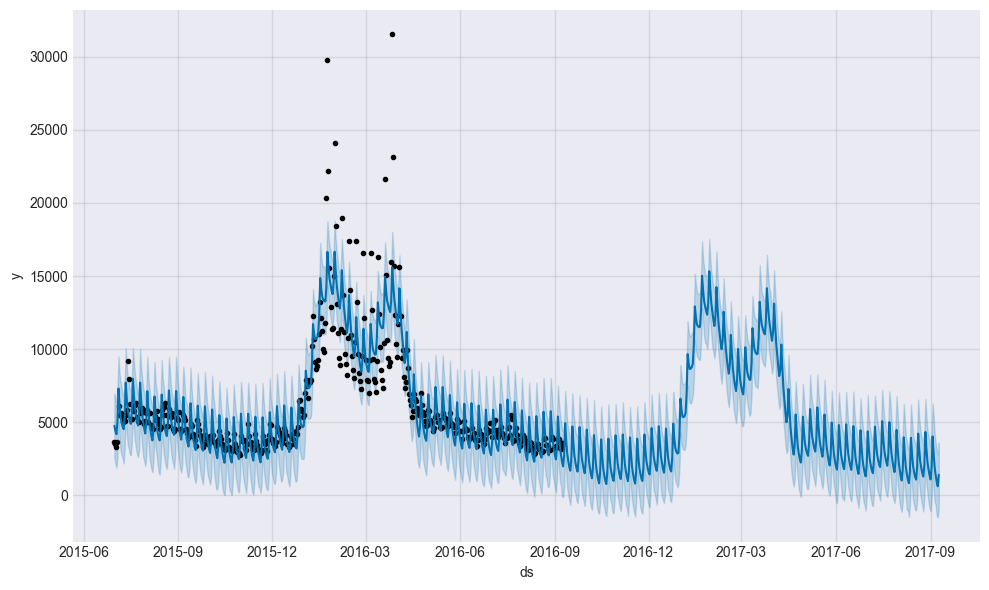

In [32]:
m = Prophet(yearly_seasonality=True)
m.fit(df_train)

future = m.make_future_dataframe(365)
forecast = m.predict(future)
fig = m.plot(forecast)

Видно что смоделировать пики удалось не очень хорошо, добавим в модель информацию о выходе нового сезона как праздник


09:25:42 - cmdstanpy - INFO - Chain [1] start processing
09:25:42 - cmdstanpy - INFO - Chain [1] done processing


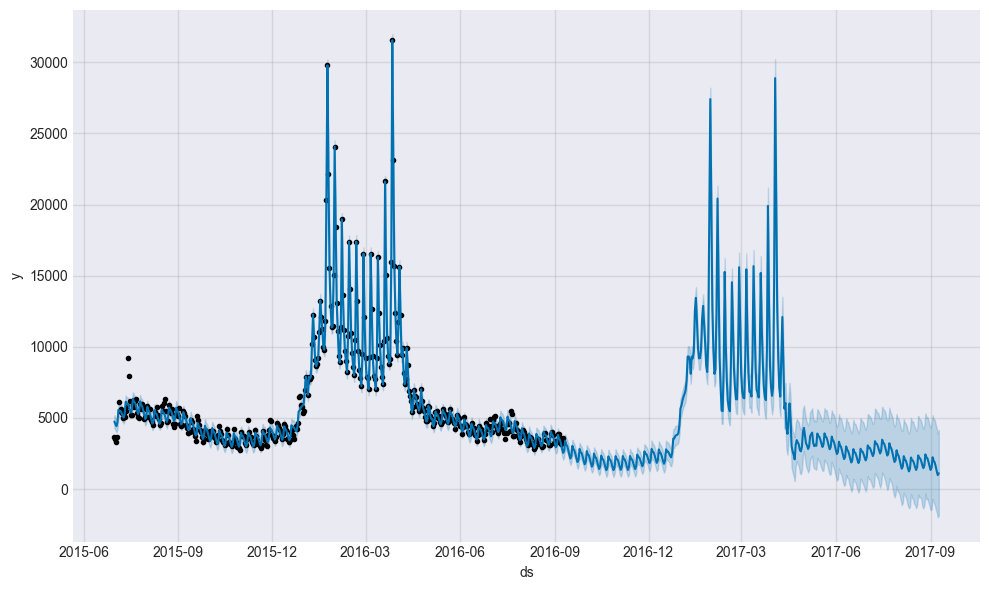

In [33]:
holidays_df = pd.DataFrame(
    {
        "holiday": "season",
        "ds": pd.to_datetime(["2016-01-23", "2017-01-29"]),
        "lower_window": -21,  # Начнем за 3 недели до выхода
        "upper_window": 90 + 14,  # Закончим через пару недель после последней серии
    }
)

m = Prophet(yearly_seasonality=True, holidays=holidays_df)
m.fit(df_train)

future = m.make_future_dataframe(365)
forecast = m.predict(future)
fig = m.plot(forecast)

Отрисуем вместе с реальными данными

In [34]:
df["forecast"] = forecast["yhat"]

<Axes: xlabel='ds'>

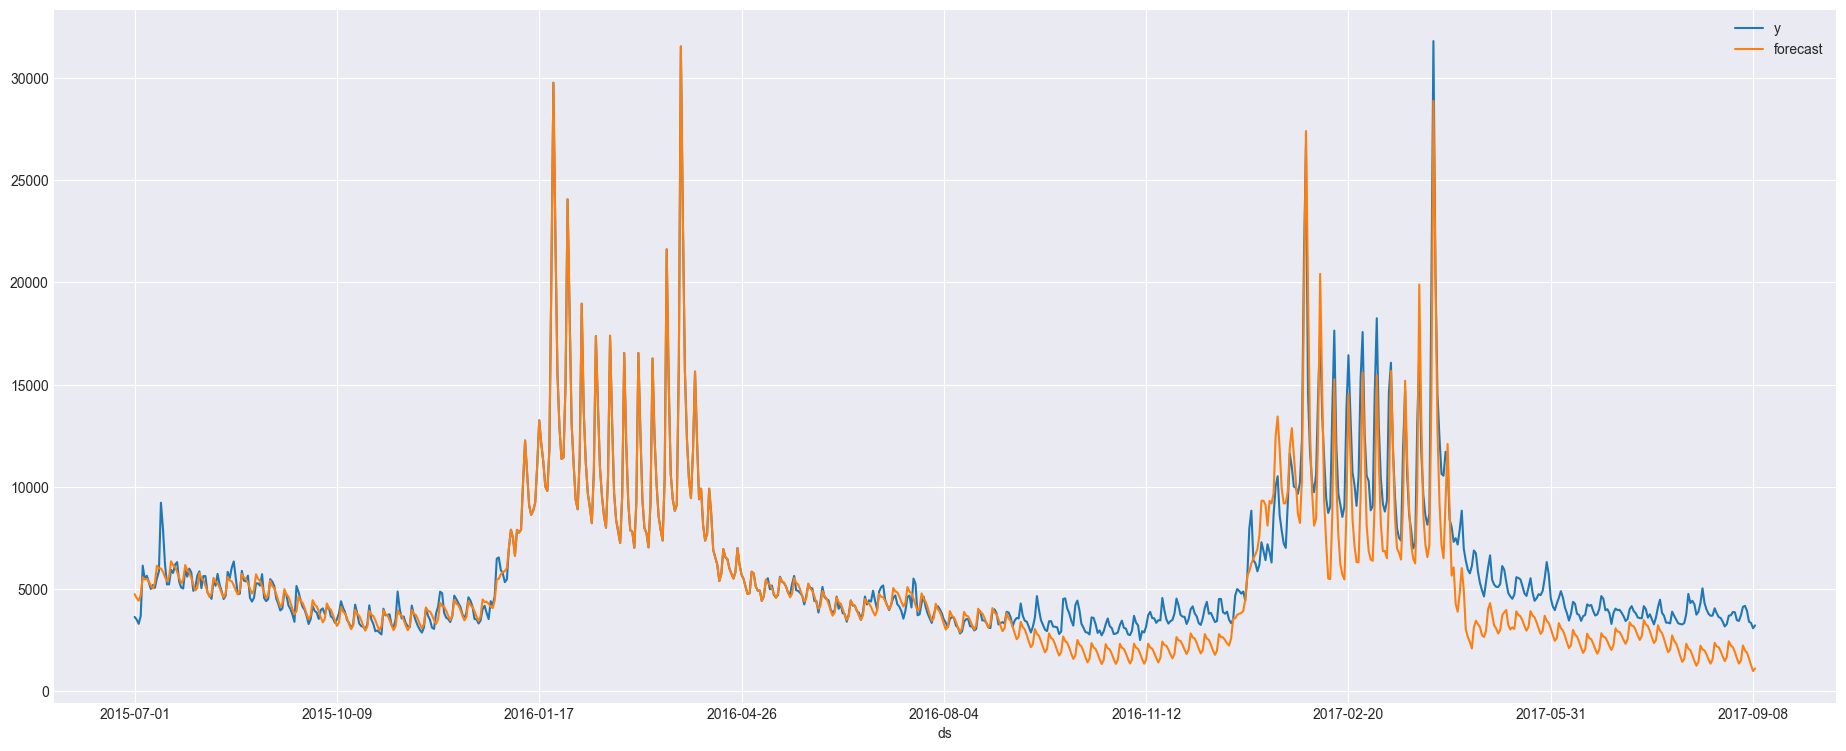

In [35]:
df.set_index("ds").plot()

## Итоги

- Прогноз разлагается на вклады отдельных компонент
- Каждую компоненту можно изучить отдельно
- Можно посмотреть как модель подобрала точки смены тренда и влиять на это поведение через `changepoint_prior_scale` (чем больше чем менее консервативное)
- Для регрессоров/праздников и сезонностей также есть визуализация влияния на прогноз + ручки для регулирования этого влияния `holidays_prior_scale` и `seasonality_prior_scale`(причем ручка есть как у группы компонент, так и у каждой компонентны отдельно)
- Для регрессоров можно получить коэффициенты линейной модели + доверительные интервалы для них